# Heat Transfer in 1D Rod- DeepXDE Implementation

## Theoretical Background

### Objective

In the previous tutorial: [heat_transfer_1- 1D rod- PyTorch.ipynb](https://github.com/neelaydoshi/PINNs-for-Beginners/blob/main/T2-%20Heat_Transfer/heat_transfer_1-%201D%20rod-%20PyTorch.ipynb), we developed PINN model using [PyTorch](https://pytorch.org/) directly. In this tutorial, we will solve solve the same problem, but using the [DeepXDE](https://github.com/lululxvi/deepxde) library. The library can use PyTorch, TensorFlow, Paddle or JAX in the backend (users choice). This library allows us to define the boundary conditions with great ease. It also handles the generation of points on the boundary and the interior regions, thus simplifying the process of generating the training/test dataset, setting up the PINN model and training it.


### Problem Statement

Let us consider a rod of length $L = 0.5 \ m$, width $w = 1\ cm$ and thermal conductivity $k = 225 \ W/m.K$. Since we are considering a 1D heat conduction, we will assume that the rod has unit depth. The left side of the wall is at a constant temperature of $100 \degree C$ (Dirichlet boundary condition). The top, bottom and right surfaces of the rod are exposed to the air at a temperature of $T_{\infty} = 10 \degree C$, with a convective heat transfer coefficient of $h = 25\ W/m^2.K$. We wish to compute the temperature profile within this rod. We will solve this using a simple PINN model and validate the result using FDM (finite difference method).



## Governing Equations

### Overview

A detailed derivation of the governing equations can be found in my previous tutorial notebook: [heat_transfer_1- 1D rod- PyTorch.ipynb](https://github.com/neelaydoshi/PINNs-for-Beginners/blob/main/T2-%20Heat_Transfer/heat_transfer_1-%201D%20rod-%20PyTorch.ipynb). Neural networks converge faster if the inputs and outputs are normalized. In the previous tutorial, we expected the PINN to output the **normalized** value of temperature $(\hat{T})$ (min-max normalization) :
$$ \displaystyle{  \hat{T} = \frac{ T - T_{\infty} }{ T_{wall} - T_{\infty} } } $$

We then **de-normalized** the output manually before computing the boundary and physics losses :
$$ T = \hat{T} \times (T_{wall} - T_{\infty}) + T_{\infty} $$

DeepXDE computes the boundary and physics losses internally and so we cannot manually de-normalize the output of the PINN. So instead, we will normalize the governing equations itself. 


### Left Boundary

$$
\begin{align}
\nonumber T_0 &= T_{wall} \\[10pt]
%%
\nonumber \hat{T}_0 \times (T_{wall} - T_{\infty}) + T_{\infty} &= T_{wall} \\[10pt]
%%
\nonumber \hat{T}_0 \times (T_{wall} - T_{\infty}) &= ( T_{wall} - T_{\infty} )
\end{align}
$$

$$
\boxed{
\hat{T}_0 = 1
}
$$

### Interior Points

$$
\begin{align}
\nonumber k \cdot w \cdot \frac{d^2 T}{d x^2} - 2 h (T - T_{\infty}) &= 0 \\[10pt]
%%
\nonumber k \cdot w \cdot \frac{d^2}{dx^2} [ \hat{T} \cdot (T_{wall} - T_{\infty}) + T_{\infty} ] - 2 h \cdot ( [ \hat{T} \cdot (T_{wall} - T_{\infty}) + T_{\infty}] - T_{\infty} ) &= 0 \\[10pt]
%%
\nonumber k \cdot w \cdot (T_{wall} - T_{\infty}) \cdot \frac{d^2 \hat{T}}{dx^2} - 2 h \cdot \hat{T} \cdot (T_{wall} - T_{\infty}) &= 0
%%
\end{align} 
$$

$$
\boxed{
k \cdot w \cdot \frac{d^2 \hat{T} }{d x^2} - 2 h \cdot \hat{T} = 0 
}
$$


### Right Boundary

$$
\begin{align}
\nonumber k \frac{dT_N}{dx} + h (T_N - T_{\infty}) &= 0 \\[10pt]
%%
\nonumber k \cdot \frac{d}{dx} [ \hat{T}_N \cdot (T_{wall} - T_{\infty}) + T_{\infty} ] + h ( [ \hat{T}_N \cdot (T_{wall} - T_{\infty}) + T_{\infty} ] - T_{\infty}) &= 0 \\[10pt]
%%
\nonumber k \cdot (T_{wall} - T_{\infty}) \cdot \frac{d \hat{T}_N }{ dx } + h \cdot \hat{T}_N \cdot (T_{wall} - T_{\infty}) &= 0 \\[10pt]
%%
\end{align}
$$

$$
\boxed{
\frac{d \hat{T}_N}{dx} = -\left(\frac{h}{k} \right) \cdot \hat{T}_N
}
$$



## Import Libraries

In [1]:
# Import libraries
import deepxde as dde
import numpy as np
import tensorflow as tf

# Set backend
dde.backend.backend_name = "pytorch"

# Check if GPU is available (its okay if it isn't)
print(f"GPU available: {dde.backend.is_gpu_available()}")


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


GPU available: True


## Setup Model

### Define Physical Parameters and Initialize Geometry 

In [2]:
##############
# Parameters
T_wall  = 100.0     # left wall temperature [°C]
T_inf   = 10.0      # ambient temperature [°C]
L       = 0.5       # rod length [m]
w       = 0.01      # width of rod [m]
k       = 225.0     # thermal conductivity [W/m.K]
h       = 25.0      # convective heat transfer coefficient [W/m^2.K]

##############
# Geometry
geom = dde.geometry.Interval(0, L)


### Define Governing ODE for Collocation Points 

Recall that the normalized governing equation is :
$$ k \cdot w \cdot \frac{d^2 \hat{T} }{d x^2} - 2 h \cdot \hat{T} = 0  $$

In the `pde()` function definition below, `hessian()` is an internal function of DeepXDE that computes the [Hessian Matrix](https://en.wikipedia.org/wiki/Hessian_matrix) of the output `y` w.r.t the input `x`. In the most generic case, the matrix would be a 3D matrix, and thus we have to pass the arguments `component`, `i` and `j` to extract the relevant output:
- `component` : The index of the output w.r.t which we wish to compute the derivative. 
- `i` : Row of the Hessian Matrix.
- `j` : Column of the Hessian Matrix.

Since our PINN will output only one variable (temperature) and has only one input argument (position), thus all the aforementioned argument are set to `0`.

**Note :** <br>
For collocation points, DeepXDE expects the PDE function to return the residual of the governing equation. Thus the funciton `pde()` has been setup accordingly.


In [3]:
##############
# PDE definition
def pde(x, y):
    d2y_dx2 = dde.grad.hessian(y, x, component=0, i=0, j=0) # second derivative of the output (d2T_dx2)
    return k*w*d2y_dx2 - 2*h*y


### Left Boundary Condition


Recall that the normalized left B.C is :
$$ \hat{T}_0 = 1 $$

The funciton `boundary_left()` below checks if the input point `x` lies on the left boundary. The `on_boundary` is an internally generated boolean variable of DeepXDE library. The `np.isclose()` function serves as a secondary check for handling floating point error.

The `dde.icbc.DirichletBC()` function of DeepXDE will first check if the input point `x` lies on the left boundary using the `boundary_left()` function. It then computes the boundary loss for the output `y` of the PINN (at left boundary) by comparing it with the desired value `1.0`. Recall that the output of the model is normalized, and thus the value `y = 1.0` corresponds to the value of $T_{wall}$.  


In [4]:
##############
# Check on-boundary left
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

##############
bc_left = dde.icbc.DirichletBC(geom, lambda x: 1.0, boundary_left)


### Right Boundary Condition

Recall the normalized equation for the right B.C :
$$ \frac{d \hat{T}_N}{dx} = -\left(\frac{h}{k} \right) \cdot \hat{T}_N $$

The `boundary_right()` funciton checks if the point `x` lies on the right boundary of the given geometry. The `on_boundary` is an DeepXDE generated boolean variable. The above equation is a [Robin B.C](https://en.wikipedia.org/wiki/Robin_boundary_condition). DeepXDE internally expects the function `robin_bc()` to return the value of the derivative, i.e., the RHS of the above equation (and NOT the residual of the equation). Thus the function `robin_bc()` has been setup accordingly.


In [5]:
##############
# Check on-boundary right
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

# Define right boundary condition : dT_dx = -(h/k)*T
def robin_bc(x, y):
    return -(h/k)*y

##############
bc_right = dde.icbc.RobinBC(geom, robin_bc, boundary_right)


## Create PINN Model

**Create Dataset :**

The `dde.data.PDE()` allows us to setup the problem statement with great ease. It takes care of computing the various boundary condition and physics losses, as well as the generation of training dataset. The value of `num_domain` corresponds to the number of collocations points we wish to generate in the interior region of the geometry, while the value `num_boundary` corresponds to the number of points to be considered on the boundary. The `num_test` argument defines the number of test dataset points generated for computing test-loss. This is different from the training dataset and this loss will NOT be used in back-probagation for weight update.

Note :<br>
- Internally, DeepXDE uses `num_boundary` to generate points for each of the given boundary condition (and NOT the boundaries itself). Suppose we had 4 B.C for the left boundary and 2 B.C for the right boundary, then we must defince at-least `num_boundary = 6`. 
- Since we have just 2 B.C (one each for each boundary), a value of `num_boundary = 2` would suffice. But we wish to be stringent about the enforcement of the B.C, so we will use `num_boundary = 4`, thus 2 points for each of the B.C will be used in the loss computation.


**Initialize PINN Model :**

- `FNN()` : Define a simple Feed-Forward Neural Network (FNN):
    - Architecture : 1 input, 3 hidden-layers with 20 neurons each and 1 output.
    - `tanh` : activation function
    - `Glorot uniform` : weight initialization


In [6]:
##############
# Define the data
data = dde.data.PDE(geom, pde, [bc_left, bc_right], num_domain=50, num_boundary=4, num_test=100)

##############
# Initialize PINN
net = dde.nn.FNN([1] + [20]*3 + [1], "tanh", "Glorot uniform")


## Run Model

### `Adam` Optimizer


- We will use `adam` optimizer, with a large initial learning rate of `lr = 0.01`, and a large decay value of `0.8` after every `1000` iterations. I have selected a large decay value of `0.8` since we are training it for just `10_000` iterations. 
- `loss_weights` : You will see that during training, the model prints 3 losses: PDE loss, Left B.C loss and Right B.C loss, respectively. The magnitude of each of these losses varies largely. Thus, we multiply them by some factor, a.k.a `loss_weights`, so that they are all given roughly equal "weightage" during training. Moreover, a larger magnitude of loss will allow the network to update the paremeters better. 


In [7]:
# Model compilation
model = dde.Model(data, net)
model.compile("adam", lr=1e-2, decay=("step", 1000, 0.8), loss_weights=[10, 100, 1000])

# Model training
losshistory, train_state = model.train(iterations=10_000, display_every=2_500)


Compiling model...
'compile' took 2.671053 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.40e+02, 1.00e+02, 1.89e+02]    [8.19e+02, 1.00e+02, 1.89e+02]    []  


c:\Users\E40065690\Documents\Learning\venvs\test_pinns\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


2500      [1.83e-01, 6.91e-03, 4.57e-04]    [1.36e-01, 6.91e-03, 4.57e-04]    []  
5000      [1.69e-02, 8.63e-05, 1.42e-05]    [1.21e-02, 8.63e-05, 1.42e-05]    []  
7500      [1.33e-02, 3.02e-05, 2.47e-06]    [1.13e-02, 3.02e-05, 2.47e-06]    []  
10000     [1.19e-02, 2.91e-05, 1.67e-06]    [1.00e-02, 2.91e-05, 1.67e-06]    []  

Best model at step 10000:
  train loss: 1.19e-02
  test loss: 1.01e-02
  test metric: []

'train' took 77.649945 s



### `L-BFGS-B` Algorithm


Since we have trained it for just `10_000` iterations, it is unlikely to have converged to the minima. Thus we will use [L-BFGS-B](https://en.wikipedia.org/wiki/Limited-memory_BFGS) optimization algorithm, which is an iterative method for solving unconstrained nonlinear optimization problems. It is a quasi-Newton second-order method and has a much faster convergence as compared to Adam optimizer. 

Note : <br>
We can use this algorithm only once we are close to the minima.


In [8]:
# Then switch to L-BFGS for fine-tuning
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

# # Display Training Plot
# dde.saveplot(losshistory, train_state, issave=False, isplot=True)

Compiling model...
'compile' took 0.000406 s

Training model...

Step      Train loss                        Test loss                         Test metric
10000     [1.19e-03, 2.91e-07, 1.67e-09]    [1.00e-03, 2.91e-07, 1.67e-09]    []  

Best model at step 10000:
  train loss: 1.19e-03
  test loss: 1.00e-03
  test metric: []

'train' took 0.008946 s



## Solution Evaluation 

**PINN Model Prediction :**

In [9]:
# Prediction
X = np.linspace(0, L, 51).reshape(-1, 1)
T_norm_pred = model.predict(X)
T_pred = T_norm_pred*(T_wall - T_inf) + T_inf

print(f'PINN | Temperature at left boundary  : {T_pred[0, 0]:.2f} deg C')
print(f'PINN | Temperature at right boundary : {T_pred[-1, 0]:.2f} deg C')


PINN | Temperature at left boundary  : 99.95 deg C
PINN | Temperature at right boundary : 26.49 deg C


**FDM Solution :**

In [10]:
# Import function
from utils_HT_1D_FDM_v1 import heat_transfer_1D_FDM

dx  = 0.01 # cell size for discretization (in m)
x_fdm, T_fdm = heat_transfer_1D_FDM(T_wall, T_inf, k, h, L, w, dx)

print(f'FDM | Temperature at right boundary : {T_fdm[0]:.2f} deg C')
print(f'FDM | Temperature at right boundary : {T_fdm[-1]:.2f} deg C')


FDM | Temperature at right boundary : 100.00 deg C
FDM | Temperature at right boundary : 26.52 deg C


## Visualization

### Comparison of PINN Solution with FDM 

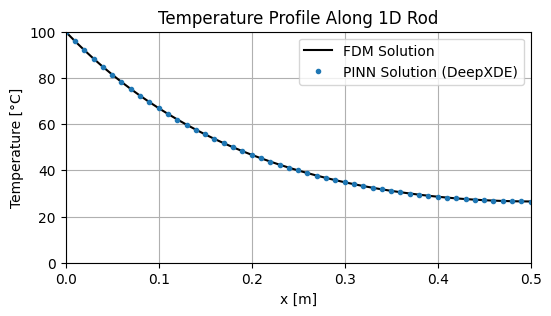

In [11]:
# Plotting
import matplotlib.pyplot as plt

# Plot the temperature profile (line plot)
plt.figure(figsize=(6, 3))
plt.plot(x_fdm, T_fdm, '-k', label='FDM Solution')
plt.plot(X, T_pred, ".", label="PINN Solution (DeepXDE)")

plt.xlabel('x [m]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature Profile Along 1D Rod')
plt.axis([0, L, 0, T_wall])
plt.legend()
plt.grid(True)
plt.show()


### Heat-map Visualization

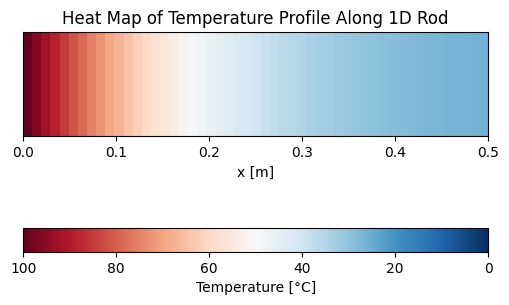

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape T_pred into a 2D array with 1 row (or a few rows for thickness)
heatmap_data = T_pred.reshape(1, -1)  # shape (1, N)

plt.figure(figsize=(6, 3))
# Display heatmap: extent sets x-axis limits, y-axis from 0 to 1 for thickness
cmap = plt.get_cmap('RdBu_r')
im = plt.imshow(heatmap_data, aspect='auto', cmap=cmap, 
                extent=[0, L, 0, 1], origin='lower',
                vmin=0, vmax=100)

cbar = plt.colorbar(im, pad=0.4, orientation='horizontal', label='Temperature [°C]')
cbar.ax.invert_xaxis()

plt.xlabel('x [m]')
plt.yticks([])  # Hide y-axis ticks as it's just a color strip
plt.title('Heat Map of Temperature Profile Along 1D Rod')
plt.show()
